# Monte Carlo Predictive coding demo for unsupervised/generative learning 

This notebook demonstrates how to train a Monte Carlo predictive coding (MCPC) model on Gaussian data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bogacz-Group/PredictiveCoding/blob/main/2_unsupervised_learning_mcpc.ipynb)

In [68]:
# import pc library of the code is being run on google colab
try:
  import google.colab
  ! git clone https://github.com/Bogacz-Group/PredictiveCoding.git
  ! cp -r PredictiveCoding/predictive_coding predictive_coding 
except ImportError:
  pass

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import predictive_coding as pc

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


### Define the training data

In [70]:
# data parameters
mean = 1.               
variance = 5.              
batch_size = 256    
nm_batches = 150        

# generate data
data = [mean + np.sqrt(variance)*torch.randn(batch_size, 1) for i in range(nm_batches)]

### Defining the model

This is the same as defining a predictive coding model with the addition of a input layer that discregard model inputs and returns a constant.

In [71]:
class BiasLayer(nn.Module):
    def __init__(self, out_features):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(torch.Tensor(1,out_features), requires_grad=True)
        nn.init.constant_(self.bias, 0.0)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu with the same shape as the input x to make sure the batch size is the same

In [72]:
latent_size = 1     # number of latent states in latent layer
output_size = 1     # number of dimensions in data 
loss_fn = lambda output, _target: 0.5*(output - _target).pow(2).sum()  # loss function is mean squared error

mcpc_model = nn.Sequential(
    BiasLayer(latent_size),
    pc.PCLayer(),
    nn.Linear(latent_size, output_size, bias=False),
)
mcpc_model.train();

### Defining the trainer

An MCPC model differs from a predictive coding model by the additional noise in its inference dynamics. This noise can be added by defining a noisy optimiser as we do in the class `SGDLD`.

Moreover, an MCPC model can be trained by sampling the activity trajectory. This code splits the inference into two parts. First a mixing period, `T_mixing`, without activity sampling followed by an activity sampling period, `T_sampling`.

In [73]:
class SGDLD(optim.SGD):
    def __init__(self, params, lr=0.01, weight_decay=0, noise_var=1.):
        super(SGDLD, self).__init__(params, lr, weight_decay)
        self.noise_var = noise_var

    def step(self, closure=None):
        super(SGDLD, self).step(closure)

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data.add_(np.sqrt(2*self.noise_var*group['lr'])*torch.randn_like(p))

In [74]:
T_mixing = 250                      # number of inference iterations without parameter gradient accumulation
T_sampling = 1                      # number of inference iterations without parameter gradient accumulation
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = SGDLD              # noisy optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam         # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1}    # optimizer parameters for p
plot_progress_at = []               # plot progress every inference iterations


trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

### Train the model

In [75]:
n_epochs = 5

for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        trainer.train_on_batch(
            inputs=pseudo_input, 
            loss_fn=loss_fn, 
            loss_fn_kwargs={'_target':y}
        )
    pbar.set_description(f"Epoch: {idx_epoch+1}")

Epoch: 5: 100%|██████████| 150/150 [00:41<00:00,  3.57it/s]


### Evaluate the model

Comparison of the data distirbution learned by the model to the actual data distribution.

The distirbution learnd by an MCPC model can be obtained by performing inference without data. However, a `PCLayer()` needs to be added to the model because a pc layer is implicitly defined during training using the loss function and the data.

In [76]:
model_generation = nn.Sequential(
    mcpc_model[:],
    pc.PCLayer() 
)
model_generation.train()    

# setup trainer for generation with large T
generation_trainer = pc.PCTrainer(model_generation, 
    T = 10000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",                      # the model is already trained
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform inference

In [77]:
nm_samples = 10240
pseudo_input = torch.zeros(nm_samples, 1) 
generation_trainer.train_on_batch(inputs=pseudo_input, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)

samples = model_generation[-1]._x.detach().cpu().numpy()

Visualise the distribution

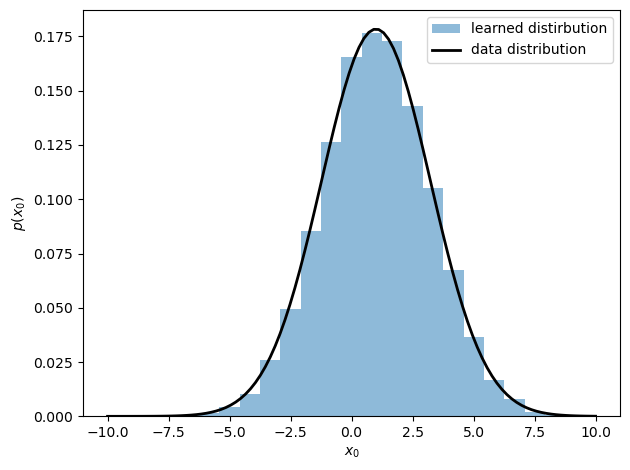

In [78]:
plt.hist(samples, bins=20, alpha=0.5, density=True, label="learned distirbution")
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*variance)*np.exp(-0.5*(x - mean)**2/variance), "k", linewidth=2, label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()